In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from IPython.display import Image

In [2]:
#%reload_ext autoreload
#%autoreload 2
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import metrics
import nmslib
import spacy
import fasttext
import fasttext.util
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context
dataset = fetch_20newsgroups(subset='all', shuffle=True, download_if_missing=True)
# http://qwone.com/~jason/20Newsgroups/

np.random.seed(123)
texts = dataset.data # Extract text
target = dataset.target # Extract target
display(len(texts))

18846

In [ ]:
texts[4]

### Glove


In [ ]:
Image('../images/glove.png', width=840, height=640)



### Word2Vec
[Word2Vec paper](https://arxiv.org/pdf/1301.3781v3.pdf)

In [ ]:
Image('../images/CBOW.png', width=320, height=320)

In [ ]:
Image('../images/SkipGram.png', width=420, height=420)

## FastText
[FastText paper](https://arxiv.org/pdf/1607.04606.pdf). 
But are more approchable explanation can be found [here](https://amitness.com/2020/06/fasttext-embeddings/):

In [ ]:
Image('../images/FastText1.png')

In [ ]:
Image('../images/FastText2.png')

In [ ]:
# I skip this step because it takes too long - just download the link in the browser:
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
#fasttext.util.download_model('en', if_exists='ignore')  # English

In [ ]:
# consumes too much RAM for me
# import fasttext
# ft = fasttext.load_model('../data/cc.en.300.bin')

In [ ]:
# this is how you can decrease the embedding size
# import fasttext.util
# fasttext.util.reduce_model(ft, 100)
# ft.get_dimension()
# ft.save_model('../data/cc.en.100.bin')

In [ ]:
ft = fasttext.load_model('../data/cc.en.100.bin')

In [ ]:
ft.get_word_vector('I am')

In [ ]:
texts = dataset.data # Extract text
target = dataset.target # Extract target

In [ ]:
X = np.array([ft.get_word_vector(t) for t in texts])

In [ ]:
X.shape

In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
# Always scale the input. The most convenient way is to use a pipeline.

clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3),
         X, target, scoring = 'f1_micro', cv=3
)

In [ ]:
np.mean(clf)

In [ ]:
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

In [ ]:
ft=None
del ft

### BERT embeddings

In [ ]:
Image('../images/BERT1.png')

In [ ]:
!python -m spacy download en_core_web_trf

In [ ]:
nlp = spacy.load(f'en_core_web_trf', disable=["tagger", "ner", "parser", "textcat"])

In [ ]:
X = [doc._.trf_data.tensors[-1] for doc in nlp.pipe(texts)]

In [ ]:
import pickle
with open('../data/spacy_embeddings.pkl', 'wb') as sink:
    pickle.dump(X, sink)

In [ ]:
import pickle
with open('../data/spacy_embeddings.pkl', 'rb') as tap:
    X = pickle.load(tap)

In [ ]:
X[5].shape

In [ ]:
X0 = np.array([i[0] for i in X])
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X0, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

In [ ]:
X1 = np.array([np.mean(i, axis=0) for i in X])
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X1, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

### universal sentence encoder
https://pypi.org/project/spacy-universal-sentence-encoder/

In [ ]:
!pip install spacy-universal-sentence-encoder

In [ ]:
import spacy_universal_sentence_encoder
nlp = spacy_universal_sentence_encoder.load_model('en_use_md')

In [ ]:
doc1 = nlp('Hi there, how are you?')
doc2 = nlp('Hello there, how are you doing today?')

In [ ]:
import numpy as np
np.dot(doc1.vector, doc2.vector)

In [ ]:
doc1.similarity(doc2)

In [ ]:
X_md = [nlp(t).vector for t in texts]
import pickle
with open('universal_sentence_encoder_embeddings.pkl', 'wb') as sink:
    pickle.dump(X_md, sink)

In [ ]:
with open('universal_sentence_encoder_embeddings.pkl', 'rb') as tap:
    X_md = pickle.load(tap)

In [ ]:
X_md[0].shape

In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
# Always scale the input. The most convenient way is to use a pipeline.
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X_md, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

In [ ]:
# norm='l2' is default
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.3)
X1 = vectorizer.fit_transform(texts)

print(f'{X1.shape[0]}, {X1.shape[1]}')


In [ ]:
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         X1, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

### Sentence-Transformers
The initial [paper](https://arxiv.org/pdf/1908.10084.pdf)

In [ ]:
Image('../images/sentence-transformers1.png')

In [ ]:
Image('../images/triplet_loss.png')

In [ ]:
!pip install nltk sentence_transformers

In [3]:
import os
os.environ['CURL_CA_BUNDLE'] = ''
from sentence_transformers import SentenceTransformer
import numpy as np
from collections import defaultdict
import json
import os
import pickle
from itertools import chain
from nltk.tokenize import sent_tokenize
import torch
import nltk
import re
nltk.download('punkt')

/home/martin/miniconda3/envs/pretrainedNN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/martin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### multilingual sentence transformer
This is the [publication](https://arxiv.org/abs/2004.09813) on this ingenious idea.

For the News-DataSet we could also use BertTopic:
https://towardsdatascience.com/topic-modeling-with-lsa-plsa-lda-nmf-bertopic-top2vec-a-comparison-5e6ce4b1e4a5

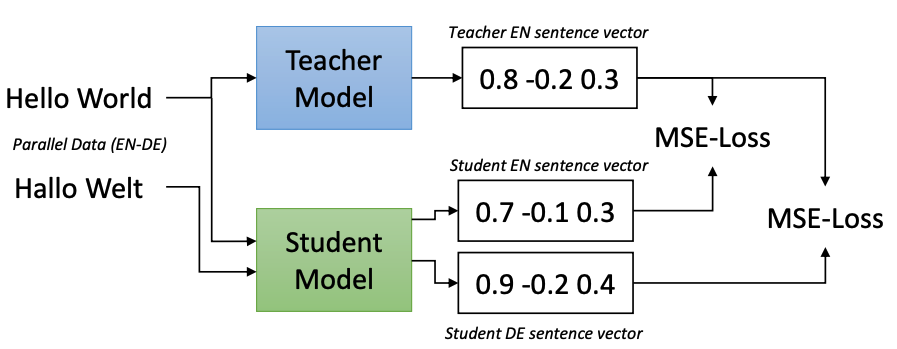

In [4]:
Image('../images/multi_sbert.png')

In [5]:
source = '/home/martin/python/fhnw_lecture/data'
try:
    model = SentenceTransformer(\
                    os.path.join(source, 'multi-qa-mpnet-base-dot-v1.pth'), device='cpu')
except:
    model = SentenceTransformer('JoBeer/multi-qa-mpnet-base-dot-v1-eclass', device='cpu')
    model.save(os.path.join(source, 'multi-qa-mpnet-base-dot-v1.pth'))

model = model.to('cpu')
model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [ ]:
with torch.no_grad():
    embeddings = model.encode(texts, device='cpu')

In [ ]:
import pickle
with open('sentence_transformer_embeddings.pkl', 'wb') as sink:
    pickle.dump(embeddings, sink)

In [ ]:
import pickle
with open('../data/sentence_transformer_embeddings.pkl', 'rb') as tap:
    embeddings = pickle.load(tap)

In [ ]:
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         embeddings, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

can we combine two different approaches? TF-IDF and the sentence embeddings?

In [ ]:
from scipy import sparse
bigX = sparse.hstack([embeddings,X1])   

In [ ]:
clf = cross_val_score(SGDClassifier(max_iter=1000, tol=1e-3, loss="perceptron"),
         bigX, target, scoring = 'f1_micro', cv=3
)
np.mean(clf)

### small demonstration

In [6]:
!pip install bs4

In [7]:
import requests
response_de=requests.get('https://www.eda.admin.ch/aboutswitzerland/de/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')
response_it = requests.get('https://www.eda.admin.ch/aboutswitzerland/it/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')
response_fr = requests.get('https://www.eda.admin.ch/aboutswitzerland/fr/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')
response_en = requests.get('https://www.eda.admin.ch/aboutswitzerland/en/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')
response_es = requests.get('https://www.eda.admin.ch/aboutswitzerland/es/home/gesellschaft/sprachen/die-sprachen---fakten-und-zahlen.html')

In [8]:
from bs4 import BeautifulSoup
soup_de = BeautifulSoup(response_de.text, features="html.parser")
soup_it = BeautifulSoup(response_it.text, features="html.parser")
soup_fr = BeautifulSoup(response_fr.text, features="html.parser")
soup_en = BeautifulSoup(response_en.text, features="html.parser")
soup_es = BeautifulSoup(response_es.text, features="html.parser")

In [9]:
soup_de


<!DOCTYPE html>

<html lang="de">
<head>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<title>Die Sprachen – Fakten und Zahlen</title>
<meta content="width=device-width, initial-scale=1.0" name="viewport"/>
<meta content="on" http-equiv="cleartype"/>
<meta content="Nebst den Landessprachen Deutsch, Französisch, Italienisch und Rätoromanisch sind Englisch und Portugiesisch in der Schweiz verbreitet." name="description"/>
<meta content="Sprachen Schweiz,Mehrsprachigkeit Schweiz,Schweizer Dialekt,Schweizerdeutsch" name="keywords"/>
<meta content="telephone=no" name="format-detection">
<meta content="Die Sprachen – Fakten und Zahlen" property="og:title"/>
<meta content="Nebst den Landessprachen Deutsch, Französisch, Italienisch und Rätoromanisch sind Englisch und Portugiesisch in der Schweiz verbreitet." property="og:description"/>
<meta content="https://www.eda.admin.ch/etc.clientlibs/eda/base/clientlibs/publis

In [10]:
import re
paragraphs_de = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_de.find_all("p")]
paragraphs_it = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_it.find_all("p")]
paragraphs_fr = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_fr.find_all("p")]
paragraphs_en = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_en.find_all("p")]
paragraphs_es = [re.sub(r'\s{1,}', ' ', para.get_text().replace('\n', ' ')).strip() for para in soup_es.find_all("p")]

In [11]:
paragraphs_it

['Cancelleria federale CF',
 'Dipartimento federale degli affari esteri DFAE',
 'Dipartimento federale dell’interno DFI',
 'Dipartimento federale di giustizia e polizia DFGP',
 'Dipartimento federale della difesa, della protezione della popolazione e dello sport DDPD',
 'Dipartimento federale delle finanze DFF',
 'Dipartimento federale dell’economia, della formazione e della ricerca DEFR',
 'Dipartimento federale dell’ambiente, dei trasporti, dell’energia e delle comunicazioni DATEC',
 'Politica europea della Svizzera',
 'Missioni internazionali di polizia della Svizzera',
 'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua e Barbuda',
 'Arabia Saudita',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaigian',
 'Bahamas',
 'Bahrein',
 'Bangladesh',
 'Barbados',
 'Belgio',
 'Belize',
 'Benin',
 'Bhutan',
 'Bielorussia',
 'Bolivia',
 'Bosnia e Erzegovina',
 'Botswana',
 'Brasile',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde

In [12]:
from sentence_transformers import SentenceTransformer
import numpy as np
from collections import defaultdict
import json
import os
source = '/home/martin/python/fhnw_lecture/data'
try:
    model = SentenceTransformer(\
                    os.path.join(source, 'paraphrase-multilingual-mpnet-base-v2.pth'), device='cpu')
except:
    model = SentenceTransformer('AIDA-UPM/mstsb-paraphrase-multilingual-mpnet-base-v2', device='cpu')
    model.save(os.path.join(source, 'paraphrase-multilingual-mpnet-base-v2.pth'))

model = model.to('cpu')
model.eval()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [13]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

all_paragraphs = paragraphs_de + paragraphs_it + paragraphs_fr + paragraphs_en + paragraphs_es
sentences = [s for p in all_paragraphs for s in sent_tokenize(p if len(p.split(' ')) > 2 else '')]

with torch.no_grad():
    multi_lang_embeddings = model.encode(sentences, device='cpu')

[nltk_data] Downloading package punkt to /home/martin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
multi_lang_embeddings.shape

(382, 768)

In [15]:
multi_lang_embeddings[3, :]

array([-6.18350180e-03,  2.11314395e-01, -7.95786642e-03,  2.11245869e-03,
       -9.27927494e-02, -4.33369614e-02,  7.04421401e-02,  6.22213446e-02,
        2.15208054e-01,  2.35122256e-02,  8.96669831e-03,  6.78615794e-02,
       -4.03414853e-02,  3.26203033e-02,  2.46334132e-02, -1.45113533e-02,
        3.74359637e-02,  1.61254220e-02, -9.69887003e-02, -8.45594779e-02,
        1.67905226e-01, -1.79829914e-02, -7.03781238e-03,  1.29314996e-02,
        2.72545801e-03,  1.38736278e-01, -2.10007504e-01, -1.73401926e-02,
        2.62062205e-03, -1.41834347e-02,  1.47858495e-02,  1.20408619e-02,
       -6.92630038e-02, -1.82107948e-02, -1.50518231e-02, -5.19081429e-02,
       -9.96747240e-02, -8.90563056e-02, -9.10346489e-03, -1.12496816e-01,
       -1.68575421e-02, -2.53451139e-01, -1.02700137e-01, -2.05921516e-01,
        8.00721273e-02, -1.89922169e-01,  1.63706109e-01, -8.64475558e-04,
       -5.15497737e-02, -3.75689529e-02,  6.84644375e-03, -6.02378100e-02,
       -2.12797150e-02, -

In [16]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### visualization via u-map

In [17]:
import umap.umap_ as umap
# import umap
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# reducer = umap.UMAP()

/home/martin/miniconda3/envs/pretrainedNN/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/miniconda3/envs/pretrainedNN/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/miniconda3/envs/pretrainedNN/lib/python3.10

In [18]:
h, w = multi_lang_embeddings.shape
normalized = multi_lang_embeddings/\
      np.resize(np.linalg.norm(multi_lang_embeddings, axis=1), (h, 1))

In [19]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10

output_notebook()

Loading BokehJS ...

In [20]:
umap_transformed = umap.UMAP().fit_transform(normalized)
# = reducer.fit_transform(normalized)

In [21]:
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.plotting import figure, output_file, save

embedding_df = pd.DataFrame(umap_transformed, columns=('x', 'y'))
embedding_df['sentences'] = sentences
# embedding_df['image'] = list(map(embeddable_image, digits.images))

datasource = ColumnDataSource(embedding_df)
color_mapping = CategoricalColorMapper(factors=[str(i) for i in np.arange(0,9)],
                                       palette=Spectral10)
output_file(filename='/home/martin/python/fhnw_lecture/images/multilang_umap.html', title = 'sentence similarity')
plot_figure = figure(
    title='UMAP projection of sentence embeddings',
    width=1000,
    height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>sentence:</span>
        <span style='font-size: 18px'>@sentences</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='sentences',transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=4
)
#save(plot_figure)
show(plot_figure)

### Monolingual models can be found on 'the Huggingface':
best [german model](https://huggingface.co/T-Systems-onsite/german-roberta-sentence-transformer-v2)